In [128]:
# pip install librosa

In [129]:
import librosa 
import librosa.display 
from IPython.display import Audio 
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
import os 
from tqdm import tqdm
import warnings 
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Concatenate
from tensorflow.keras.layers import MultiHeadAttention, LayerNormalization, Dense, Input
from tensorflow.keras.layers import Input, Lambda

In [130]:
base_path = "./data"

In [131]:
audio_files = [f for f in os.listdir(base_path) if f.endswith(".wav")]

In [132]:
#  info extract from file names 
def extract(filename):
    parts = filename.split("-")
    if len(parts) < 4: 
        return None
    
    gender = "Male" if parts[0] == "M" else "Female" 
    emotion = {"A": "Angry", "H": "Happy", "N": "Neutral", "S": "Sad"}.get(parts[1][0], "unknown")
    version = parts[1][1]
    category = parts[2]
    unique_id = parts[3].split(".")[0]
    
    return {"filename": filename, "gender": gender, "emotion": emotion, "version": version, "category": category, "unique_id": unique_id}

In [133]:
df = pd.DataFrame([extract(f) for f in audio_files if extract(f) is not None])

In [134]:
# check the dfs
import ace_tools_open as tools

tools.display_dataframe_to_user(name="EDA speech datas", dataframe = df)

EDA speech datas


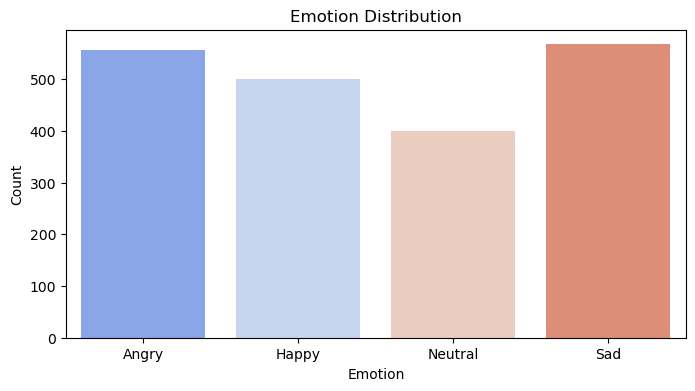

In [135]:
#EDA 
# number of emotions 
plt.figure(figsize=(8, 4))
sns.countplot(data=df, x="emotion", palette="coolwarm")
plt.title("Emotion Distribution")
plt.xlabel("Emotion")
plt.ylabel("Count")
plt.show()

Loading audio files: 100%|██████████| 2023/2023 [00:40<00:00, 49.84it/s]


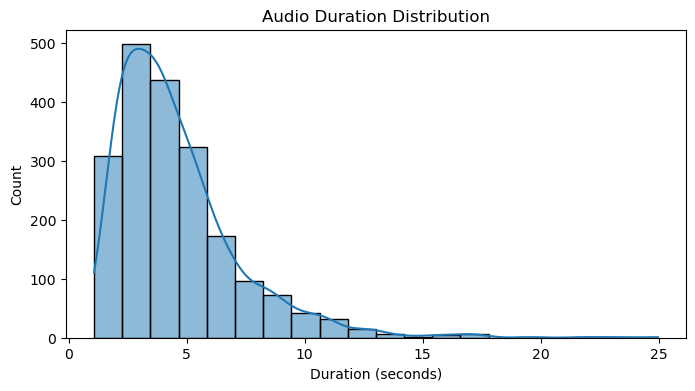

In [136]:
# check the audio length 
audio_durations = []

for file in tqdm(df["filename"], desc="Loading audio files"):
    file_path = os.path.join(base_path, file)
    y, sr = librosa.load(file_path, sr=None)
    duration = librosa.get_duration(y=y, sr=sr)
    audio_durations.append(duration)

df["duration"] = audio_durations

plt.figure(figsize=(8, 4))
sns.histplot(df["duration"], bins=20, kde=True)
plt.title("Audio Duration Distribution")
plt.xlabel("Duration (seconds)")
plt.ylabel("Count")
plt.show()

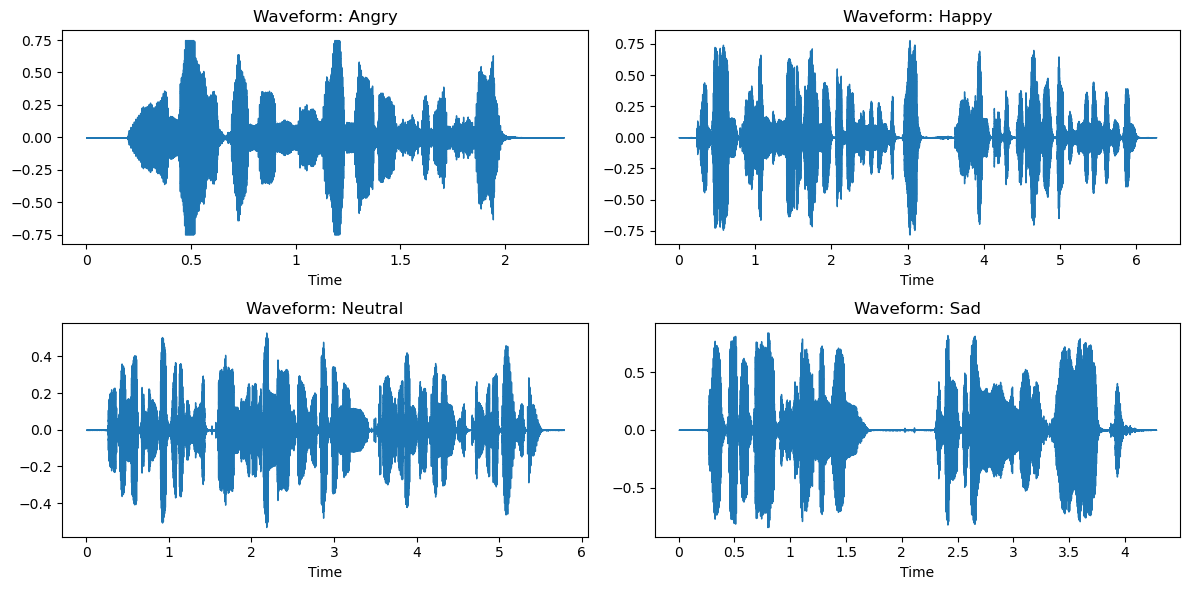

In [137]:
unique_emotions = df["emotion"].unique() 

plt.figure(figsize=(12, 6))
for i, emotion in enumerate(unique_emotions):
    file = df[df["emotion"] == emotion].sample(1)["filename"].values[0]
    y, sr = librosa.load(os.path.join(base_path, file), sr=None)
    
    plt.subplot(2, 2, i+1)
    librosa.display.waveshow(y, sr=sr)
    plt.title(f"Waveform: {emotion}")
plt.tight_layout()
plt.show()

-> angry는 초반에는 조용하다가 높은 폭변화를 보임 , 불규칙적이고 급변한 변화가 많음 

-> happy는 일정한 리듬과 폭이 높고 변화가 많지만 angry보다는 일정

-> Neural는변화가 적은 평탄 한 타입

-> sad는 비교적 긴 지속시간을 가지면서 기복이 조금있음 


-> 아마 neutral과 sad를 혼동할 경우가 많을것으로 예상됨.

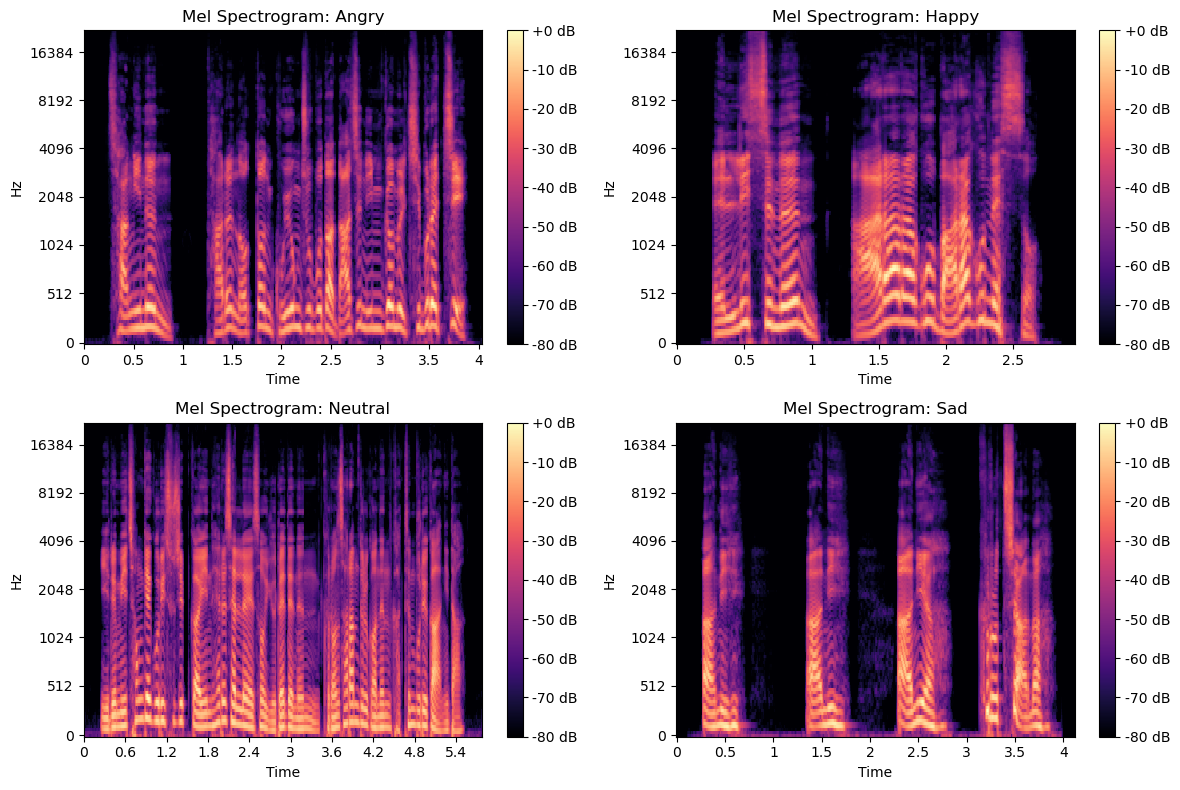

In [138]:
plt.figure(figsize=(12, 8))
for i, emotion in enumerate(unique_emotions):
    file = df[df["emotion"] == emotion].sample(1)["filename"].values[0]
    file_path = os.path.join(base_path, file)
    y, sr = librosa.load(file_path, sr=None)

    S = librosa.feature.melspectrogram(y=y, sr=sr)
    S_db = librosa.power_to_db(S, ref=np.max)


    plt.subplot(2, 2, i+1)
    librosa.display.specshow(S_db, sr=sr, x_axis='time', y_axis='mel')
    plt.title(f"Mel Spectrogram: {emotion}")
    plt.colorbar(format='%+2.0f dB')
plt.tight_layout()
plt.show()

In [139]:
# Before analyzing the datas , let's start the" Feature Extraction"
# 1. MFCC(Mel frequency Cepstral coeffcients): 음성시 중요한 주파수 특징을 추출하기위함(sad, neutral 구분율 높이기위함)
# 2. zero- crossing rate( ZCR): 음성신호가 0을 몇번 통과하는지 계산(음성 vs무성음 구분하기위함)
# 3. chroma features : 음성의 주파수 성분을 12개의 피처 클래스로 변환()-> 감정분석에 유용하게 사용하기위함

In [140]:
def extract_features(file_path):
    y, sr = librosa.load(file_path, sr=None)
    
    # MFCC (Mel-Frequency Cepstral Coefficients)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    mfcc_mean = np.mean(mfcc, axis=1)  # 평균값 계산
    
    # Zero-Crossing Rate
    zcr = librosa.feature.zero_crossing_rate(y)
    zcr_mean = np.mean(zcr)
    
    # Chroma Features 
    chroma = librosa.feature.chroma_stft(y=y, sr=sr)
    chroma_mean = np.mean(chroma, axis=1)
    
    # feature  vector RETURN 
    return np.concatenate([mfcc_mean, [zcr_mean], chroma_mean])

features = []
for file in tqdm(df["filename"], desc="Extracting features"):
    file_path = os.path.join(base_path, file)
    feature_vector = extract_features(file_path)
    features.append(feature_vector)

feature_columns = [f"mfcc_{i}" for i in range(13)] + ["zcr"] + [f"chroma_{i}" for i in range(12)]
df_features = pd.DataFrame(features, columns=feature_columns)
df_features["emotion"] = df["emotion"] 

tools.display_dataframe_to_user(name="extracted audio featuers", dataframe=df_features)

Extracting features: 100%|██████████| 2023/2023 [00:51<00:00, 39.12it/s]

extracted audio featuers


In [141]:
df_features["emotion"].value_counts()

emotion
Sad        567
Angry      557
Happy      500
Neutral    399
Name: count, dtype: int64

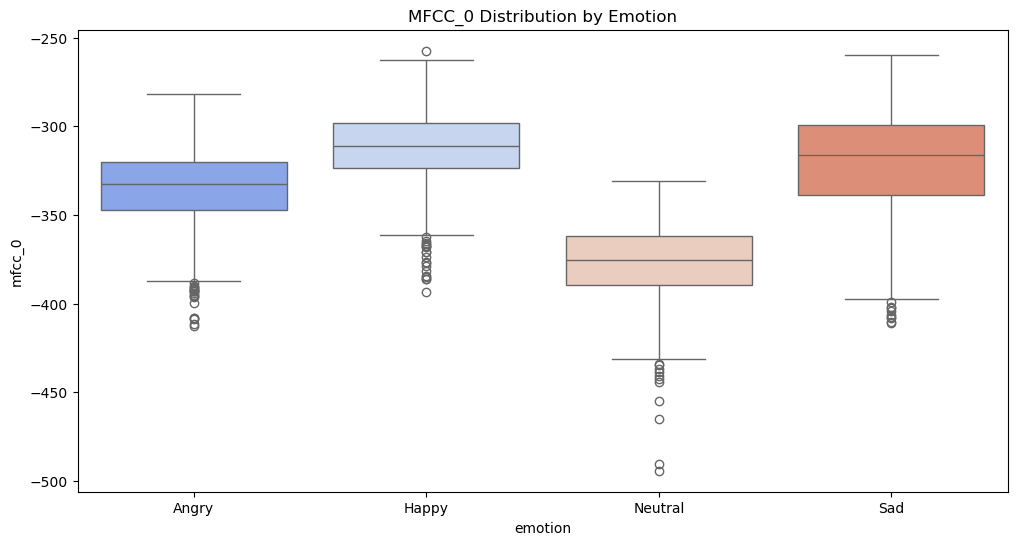

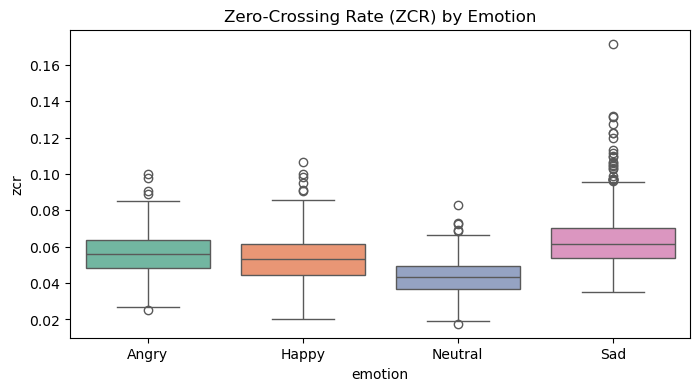

In [142]:
# check the how feature's distribute
plt.figure(figsize=(12, 6))

# 감정별 MFCC 첫 번째 특징 비교
sns.boxplot(data=df_features, x="emotion", y="mfcc_0", palette="coolwarm")
plt.title("MFCC_0 Distribution by Emotion")
plt.show()

# 감정별 ZCR 비교
plt.figure(figsize=(8, 4))
sns.boxplot(data=df_features, x="emotion", y="zcr", palette="Set2")
plt.title("Zero-Crossing Rate (ZCR) by Emotion")
plt.show()

In [143]:
# prepare for training 
df_features.to_csv("speech_emotion_features.csv", index=False)

In [144]:
df_features = pd.read_csv("speech_emotion_features.csv")
df_features.head()

,mfcc_0,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,mfcc_9,...,chroma_3,chroma_4,chroma_5,chroma_6,chroma_7,chroma_8,chroma_9,chroma_10,chroma_11,emotion
0,-339.956665,107.974815,-17.054428,25.328472,14.945503,5.040310,-16.776907,4.413867,5.075844,-9.872041,...,0.468850,0.475023,0.496912,0.503756,0.525647,0.481538,0.455647,0.474289,0.474948,Angry
1,-312.309906,108.363487,-26.046255,21.757904,10.605204,6.663714,-17.952904,2.413924,7.300962,-9.452870,...,0.469090,0.527223,0.483865,0.456218,0.449086,0.413626,0.384323,0.389607,0.418336,Angry
2,-311.304413,92.640915,-24.373222,25.054802,12.751621,12.174802,-17.012188,3.495239,4.636253,-5.898817,...,0.459165,0.457275,0.524941,0.548078,0.616799,0.576925,0.493198,0.435239,0.431485,Angry
3,-343.205597,112.224571,-14.558778,13.581340,5.540829,-2.070308,-11.961161,5.717340,8.653909,-11.186260,...,0.534989,0.543373,0.513261,0.441184,0.383551,0.342053,0.345604,0.392052,0.435690,Angry
4,-338.741211,111.817543,-19.642500,21.322334,7.580974,0.375608,-13.614339,8.950939,6.971617,-8.260814,...,0.420869,0.486925,0.546218,0.495606,0.458740,0.429354,0.441550,0.489245,0.449383,Angry


In [145]:
X = df_features.drop(columns=["emotion"]).values
y = df_features["emotion"].values

In [146]:
# emotion label encoding 
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)
y_onehot = tf.keras.utils.to_categorical(y_encoded)

In [147]:
X_train, X_test, y_train, y_test = train_test_split(X, y_onehot, 
                                                    test_size=0.2,
                                                    random_state=42, 
                                                    stratify=y_onehot)

In [148]:
X_train.shape

(1618, 26)

In [149]:
X_test.shape

(405, 26)

#### **LSTM**

In [150]:
lstm = Sequential([
    tf.keras.layers.Reshape((X_train.shape[1], 1), input_shape=(X_train.shape[1],)), 
    LSTM(64, return_sequences=True, activation='relu'),
    LSTM(32, activation='relu'),
    Dropout(0.3),
    Dense(16, activation='relu'),
    Dense(y_train.shape[1], activation='softmax') 
])
lstm.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ reshape_4 (Reshape)             │ (None, 26, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 26, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 4)              │            68 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,908 (116.83 KB)

 Trainable params: 29,908 (116.83 KB)

 Non-trainable params: 0 (0.00 B)

In [151]:
lstm.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history_lstm = lstm.fit(X_train, y_train, epochs=30, batch_size=16, validation_data=(X_test, y_test))

Epoch 1/30
102/102 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.3584 - loss: 1.4560 - val_accuracy: 0.8370 - val_loss: 0.6347
Epoch 2/30
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7833 - loss: 0.5300 - val_accuracy: 0.9284 - val_loss: 0.1995
Epoch 3/30
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9107 - loss: 0.2434 - val_accuracy: 0.9358 - val_loss: 0.1484
Epoch 4/30
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8904 - loss: 0.3386 - val_accuracy: 0.9235 - val_loss: 0.1990
Epoch 5/30
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9514 - loss: 0.1572 - val_accuracy: 0.8914 - val_loss: 0.2433
Epoch 6/30
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9418 - loss: 0.1860 - val_accuracy: 0.9235 - val_loss: 0.1798
Epoch 7/30
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9565 - loss: 0.1271 - val_accuracy: 0.9259 - val_loss: 0.2258
Epoch 8/30
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9336 - loss: 0.2127 - val_accuracy: 0.

### **CNN**

In [152]:
cnn = Sequential([
    tf.keras.layers.Reshape((X_train.shape[1], 1), input_shape=(X_train.shape[1],)),  
    Conv1D(32, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Conv1D(64, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(y_train.shape[1], activation='softmax') 
])

cnn.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ reshape_5 (Reshape)             │ (None, 26, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 24, 32)         │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 12, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 10, 64)         │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_4 (MaxPooling1D)  │ (None, 5, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 320)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 64)             │        20,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,140 (106.02 KB)

 Trainable params: 27,140 (106.02 KB)

 Non-trainable params: 0 (0.00 B)

In [153]:
cnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history_cnn = cnn.fit(X_train, y_train, epochs=30, batch_size=16, validation_data=(X_test, y_test))

Epoch 1/30
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5017 - loss: 1.8529 - val_accuracy: 0.9086 - val_loss: 0.3670
Epoch 2/30
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8373 - loss: 0.4016 - val_accuracy: 0.9210 - val_loss: 0.2482
Epoch 3/30
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9079 - loss: 0.2660 - val_accuracy: 0.9383 - val_loss: 0.1657
Epoch 4/30
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9168 - loss: 0.2279 - val_accuracy: 0.9531 - val_loss: 0.1236
Epoch 5/30
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9201 - loss: 0.2064 - val_accuracy: 0.9457 - val_loss: 0.1464
Epoch 6/30
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9037 - loss: 0.2578 - val_accuracy: 0.9506 - val_loss: 0.1244
Epoch 7/30
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9398 - loss: 0.1693 - val_accuracy: 0.9531 - val_loss: 0.1273
Epoch 8/30
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9325 - loss: 0.1926 - val_accuracy: 0.

#### **Transformer**

###### 참고:https://kjwony.tistory.com/20

In [154]:
def transformer_encoder(inputs, num_heads=4, key_dim = 64):
    attn_output = MultiHeadAttention(num_heads=num_heads, key_dim=key_dim)(inputs, inputs) # 음성특징을 여러관점에서 볼수있게함
    norm1 = LayerNormalization(epsilon=1e-6)(inputs + attn_output) # 안정적으로 학습하기 위해 추가해줌

    dense_output = Dense(128, activation="relu")(norm1)
    dense_output = Dense(inputs.shape[-1], activation="relu")(dense_output)
    norm2 = LayerNormalization(epsilon=1e-6)(norm1 + dense_output)
    
    return norm2

In [155]:
inputs = Input(shape=(X_train.shape[1],1))

In [156]:
# add encoder block
x = transformer_encoder(inputs)
x = transformer_encoder(x)
x = Flatten()(x)
x = Dense(64, activation="relu")(x)
x = Dense(y_train.shape[1], activation="softmax")(x)

In [157]:
transformer = Model(inputs, x)

transformer.compile(optimizer='adam', loss = 'categorical_crossentropy', metrics=['accuracy'])

history_transformer = transformer.fit(X_train, y_train, epochs=30, batch_size=16, validation_data=(X_test, y_test))

Epoch 1/30
102/102 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.2808 - loss: 1.3856 - val_accuracy: 0.2741 - val_loss: 1.3831
Epoch 2/30
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.2778 - loss: 1.3821 - val_accuracy: 0.2815 - val_loss: 1.3808
Epoch 3/30
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.2973 - loss: 1.3781 - val_accuracy: 0.2815 - val_loss: 1.3794
Epoch 4/30
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.2952 - loss: 1.3776 - val_accuracy: 0.2815 - val_loss: 1.3786
Epoch 5/30
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.2697 - loss: 1.3805 - val_accuracy: 0.2815 - val_loss: 1.3783
Epoch 6/30
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.2842 - loss: 1.3792 - val_accuracy: 0.2815 - val_loss: 1.3779
Epoch 7/30
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.2655 - loss: 1.3769 - val_accuracy: 0.2815 - val_loss: 1.3777
Epoch 8/30
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.2961 - loss: 1.3754 - val_accuracy: 0.

In [158]:
histories = {
    "LSTM": history_lstm,
    "CNN": history_cnn,
    "Transformer": history_transformer
}

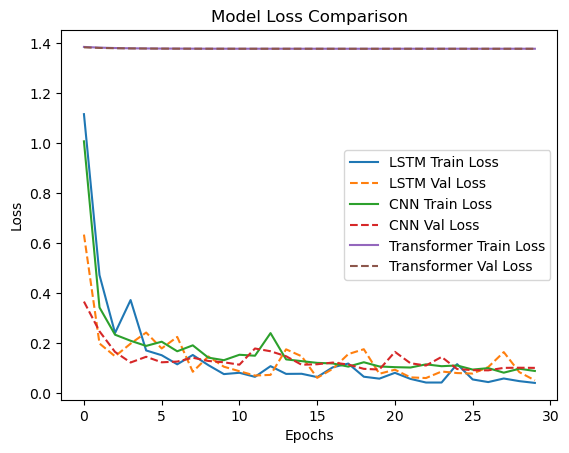

In [159]:
# losses
for name, history in histories.items():
    plt.plot(history.history["loss"], label=f"{name} Train Loss")
    plt.plot(history.history["val_loss"], label=f"{name} Val Loss", linestyle="dashed")

plt.title("Model Loss Comparison")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

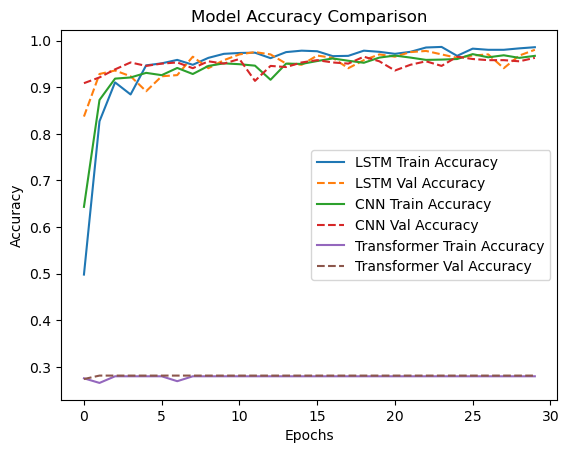

In [160]:
# accuracy 
for name, history in histories.items():
    plt.plot(history.history["accuracy"], label=f"{name} Train Accuracy")
    plt.plot(history.history["val_accuracy"], label=f"{name} Val Accuracy", linestyle="dashed")

plt.title("Model Accuracy Comparison")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

#### **loss 해석**
LSTM, CNN모델에서 loss값이 0근처에 유지되는걸 확인 -> 안정적으로 수렴


Transformer는 1.4정도에서 정체 -> 학습되지 않거나 epoch수가 작은가?  vanishing gradient 문제가 있나? 의심 가능 -> 일단 lr을 조절해서 다시확인해봐야할듯

#### **accuracy해석**
LSTM, CNN은 train, val accuracy모두 95%이상 유지 

Transfomer모델은 약 30%에서 전혀 개선되지않음  -> 훈련제대로 안됐단의미

In [161]:
best_accuracy_dict = {
    "Model": list(histories.keys()),
    "Train Accuracy": [max(history.history["accuracy"]) for history in histories.values()],  # 최고 Train 정확도
    "Validation Accuracy": [max(history.history["val_accuracy"]) for history in histories.values()]  # 최고 Validation 정확도
}
df_accuracy = pd.DataFrame(best_accuracy_dict)

In [162]:
df_accuracy

,Model,Train Accuracy,Validation Accuracy
0,LSTM,0.986403,0.980247
1,CNN,0.970952,0.965432
2,Transformer,0.279975,0.281481


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


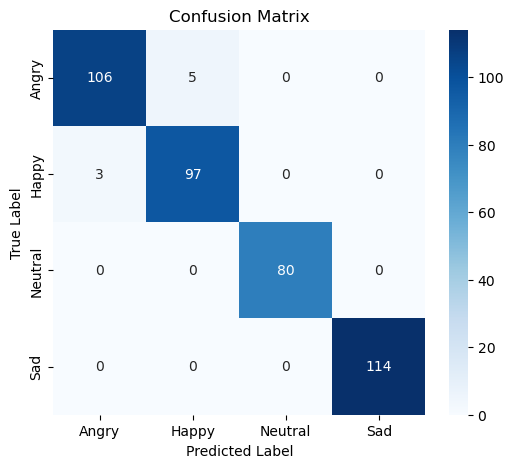

In [163]:
from sklearn.metrics import confusion_matrix
y_pred = lstm.predict(X_test)  # LSTM 기준, CNN/Transformer도 동일하게 진행 가능
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Confusion Matrix 생성
cm = confusion_matrix(y_true_classes, y_pred_classes)

# 감정 라벨 설정
emotion_labels = encoder.classes_  # 감정별 라벨 리스트 가져오기

# Confusion Matrix 시각화
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=emotion_labels, yticklabels=emotion_labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

대부분의 경우 잘 예측 되는 것으로 보이지만 neural과 sad사이의 혼동이 있음(예상한대로로).

In [164]:
print(classification_report(y_true_classes, y_pred_classes, target_names=emotion_labels))

              precision    recall  f1-score   support

       Angry       0.97      0.95      0.96       111
       Happy       0.95      0.97      0.96       100
     Neutral       1.00      1.00      1.00        80
         Sad       1.00      1.00      1.00       114

    accuracy                           0.98       405
   macro avg       0.98      0.98      0.98       405
weighted avg       0.98      0.98      0.98       405



In [165]:
# 성능 욕심. softvoting vs feature selection  을 통한 성능 추가 비교! 

#### **Ensemble(cnn+lstm -> softvoting)**

In [166]:
def create_soft_voting_ensemble(cnn_model, lstm_model):
    # 입력 레이어 재사용
    input_shape = cnn_model.input_shape[1:]
    input_layer = Input(shape=input_shape)
    
    # 각 모델의 예측 계산
    cnn_output = cnn_model(input_layer)
    lstm_output = lstm_model(input_layer)
    
    # Soft Voting 구현 (두 모델의 예측 확률 평균)
    ensemble_output = Lambda(lambda x: (x[0] + x[1]) / 2)([cnn_output, lstm_output])
    
    ensemble_sv = Model(inputs=input_layer, outputs=ensemble_output)
    
    return ensemble_sv

ensemble_sv = create_soft_voting_ensemble(cnn, lstm)

ensemble_sv.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

#### **Ensemble(cnn+lstm-> feature selection)**

In [167]:
# cnn + lstm ( feature selection) -> ensemble
input_layer = Input(shape=(X_train.shape[1], 1))

# CNN 부분
cnn_branch = Conv1D(64, kernel_size=3, activation='relu')(input_layer)
cnn_branch = MaxPooling1D(pool_size=2)(cnn_branch)
cnn_branch = Flatten()(cnn_branch)

# LSTM 부분
lstm_branch = LSTM(64, return_sequences=True)(input_layer)
lstm_branch = LSTM(32)(lstm_branch)

# merged cnn + lstm parts
merged = Concatenate()([cnn_branch, lstm_branch])
merged = Dense(64, activation='relu')(merged)
merged = Dense(y_train.shape[1], activation='softmax')(merged)

ensemble_fs = Model(inputs=input_layer, outputs=merged)

ensemble_fs.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
ensemble_fs.fit(X_train, y_train, epochs=30, batch_size=16, validation_data=(X_test, y_test))

Epoch 1/30
102/102 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.5629 - loss: 1.8043 - val_accuracy: 0.8864 - val_loss: 0.2884
Epoch 2/30
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8888 - loss: 0.2858 - val_accuracy: 0.8988 - val_loss: 0.2343
Epoch 3/30
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9487 - loss: 0.1673 - val_accuracy: 0.9531 - val_loss: 0.1431
Epoch 4/30
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9439 - loss: 0.1543 - val_accuracy: 0.9531 - val_loss: 0.1402
Epoch 5/30
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9481 - loss: 0.1454 - val_accuracy: 0.9062 - val_loss: 0.2400
Epoch 6/30
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9468 - loss: 0.1395 - val_accuracy: 0.9630 - val_loss: 0.1016
Epoch 7/30
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9612 - loss: 0.1000 - val_accuracy: 0.9531 - val_loss: 0.1196
Epoch 8/30
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9700 - loss: 0.1015 - val_accuracy: 0

In [168]:
ensemble_pred = ensemble_fs.predict(X_test)
ensemble_final_prediction = np.argmax(ensemble_pred, axis=1)

# ensemble성능 평가
y_true = np.argmax(y_test, axis=1)
print(classification_report(y_true, ensemble_final_prediction, target_names=encoder.classes_))

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
              precision    recall  f1-score   support

       Angry       0.98      0.86      0.92       111
       Happy       0.85      0.98      0.91       100
     Neutral       0.96      1.00      0.98        80
         Sad       1.00      0.96      0.98       114

    accuracy                           0.95       405
   macro avg       0.95      0.95      0.95       405
weighted avg       0.95      0.95      0.95       405



둘다 모두 이전 기본 모델들 모다는 성능이 오른 것을 확인! 

그러나 ensemble 했을 때의 모델은  균형 잡힌 예측이 살짝 부족한 편 

-> neutral, sad에서는 99~100까지의 성능을 보이지만 happy에서는 91정도의 다소낮은 성능을 보임 angry는 재현율은 높지만 정밀도가 낮아 오예측이 많은 가능성있음! 

-> 최종적으로 best model로서 ""균형잡인 성능을 가진 softvoting ensemble을 진행한 모델 선정"" 

In [169]:
ensemble_sv.save('ensemble_soft_voting_model.h5')

#### **여기서 궁금증 !!! 실시간으로 녹음된 내 목소리의 감정 분류도 가능할까?**

In [170]:
# pip install sounddevice

In [ ]:
import sounddevice as sd
import soundfile as sf 
import datetime

duration = 5 # set the recording time (sec)
sample_rate = 22050  

save_dir = "./new-recorded"
os.makedirs(save_dir, exist_ok=True)

# 파일 이름은 datetime으로 생성
timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
audio_filename = f"recorded_{timestamp}.wav"
audio_filepath = os.path.join(save_dir, audio_filename)

print("녹음 중 .. 말하세요...")
audio = sd.rec(int(duration * sample_rate), samplerate=sample_rate, channels=1, dtype=np.float32)
sd.wait()

# 1D 배열로 변환
audio = audio.flatten()

sf.write(audio_filepath, audio, sample_rate)
print(f"녹음 완료되었어요! \n저장된 파일: {audio_filepath}")

녹음 중 .. 말하세요...
녹음 완료되었어요! 
저장된 파일: ./new-recorded\recorded_20250313_164057.wav


In [180]:
def extract_features(audio, sample_rate=22050):
    mfcc = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=13)
    mfcc_mean = np.mean(mfcc, axis=1)

    zcr = librosa.feature.zero_crossing_rate(audio)
    zcr_mean = np.mean(zcr)

    chroma = librosa.feature.chroma_stft(y=audio, sr=sample_rate)
    chroma_mean = np.mean(chroma, axis=1)

    feature_vector = np.concatenate([mfcc_mean, [zcr_mean], chroma_mean])
    return feature_vector.reshape(1, -1)

# 특징 추출
features = extract_features(audio)
print("complete the feature extraction:", features.shape)

complete the feature extraction: (1, 26)


In [181]:
# 선택한 best model load
model = tf.keras.models.load_model("ensemble_soft_voting_model.h5")  

emotion_labels = ["Angry", "Happy", "Neutral", "Sad"]

prediction = model.predict(features)
predicted_class = np.argmax(prediction)  

print(f"predict emotion: {emotion_labels[predicted_class]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step
predict emotion: Happy


###### 수업 중에 녹음해서그런지 강사님 약간의 웃는 목소리가 들어갔어여 그래서그런지  happy로 분류된 걸 확인가능합니다!